<a href="https://colab.research.google.com/github/pkhuynhNCAT/MVSeg2023-SwinUNETR/blob/main/Mitral_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ------------  CELL 1  (INSTALL)  ------------
# Compatible versions: NumPy 1.26.4  •  PyTorch 2.3 (CUDA 11.8)  •  MONAI 1.4
!pip -q install --upgrade pip
!pip -q install numpy==1.26.4                       # modern enough for JAX / skimage etc.
!pip -q install --extra-index-url https://download.pytorch.org/whl/cu118 \
    torch==2.3.0 torchvision torchaudio
!pip -q install "monai[all]==1.4.0" nibabel scikit-image \
    pyvista==0.45.2 einops tqdm
import os, sys
print("\n🔄  Kernel will restart once installs finish …")
os.kill(os.getpid(), 9)         # ← Colab reconnects automatically

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 158.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 MB 155.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 149.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 130.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 154.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 132.1 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
# ==============================================================
#  3-D TEE MITRAL VALVE  ·  END-TO-END PIPELINE (single cell)
#  – Swin-UNETR training / val / test
#  – STL export with entropy QA
#  – Publication-ready qualitative viewer
# ==============================================================

# ───────────────── 1. settings ────────────────────────────────
DRIVE_ROOT  = "/content/drive/MyDrive/mvseg2023"
EPOCHS      = 120
PATIENCE    = 15
QA_THRESH   = 0.80
TEMP_SCALE  = 2.0
BATCH_SIZE  = 1
pix         = (0.6,0.6,0.6)

# ───────────────── 2. mount + unzip ───────────────────────────
from google.colab import drive; drive.mount("/content/drive", force_remount=True)
import os, zipfile, glob, re, warnings, tqdm, random, csv, numpy as np
warnings.filterwarnings("ignore")
RAW = "/content/mvseg_raw"
if not os.path.exists(RAW):
    os.makedirs(RAW, exist_ok=True)
    for z in ("train.zip","val.zip","test.zip"):
        with zipfile.ZipFile(f"{DRIVE_ROOT}/{z}") as zf:
            print("⏬ extracting", z); zf.extractall(RAW)
print("✅ NIfTI files:", len(glob.glob(f"{RAW}/**/*.nii*", recursive=True)))

# ───────────────── 3. split files ─────────────────────────────
def gather(split):
    pat = re.compile(rf"{split}_[0-9]+-US\.nii(\.gz)?$")
    out=[]
    for img in glob.glob(f"{RAW}/**/*.nii*", recursive=True):
        if pat.search(os.path.basename(img)):
            lbl=img.replace("-US.nii","-label.nii").replace("-US.nii.gz","-label.nii.gz")
            if os.path.exists(lbl): out.append({"image":img,"label":lbl})
    return sorted(out,key=lambda d:d["image"])
train_files,val_files,test_files = gather("train"),gather("val"),gather("test")
print(f"🥧 train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

# ───────────────── 4. transforms / loaders ────────────────────
from monai.transforms import *
from monai.data        import CacheDataset, DataLoader
common = [
    LoadImaged(["image", "label"]),  # keep meta-dicts
    EnsureChannelFirstd(["image", "label"]),
    Spacingd(["image", "label"], pix, mode=("bilinear", "nearest")),
    Orientationd(["image", "label"], axcodes="RAS"),
    ScaleIntensityRangePercentilesd("image", 1, 99, b_min=0, b_max=1, clip=True),
    CropForegroundd(["image", "label"], source_key="label"),
]
aug=[RandHistogramShiftd("image",prob=.3),
     RandGaussianNoised("image",prob=.3,std=.01),
     RandFlipd(["image","label"],prob=.5,spatial_axis=[0,1,2]),
     RandRotate90d(["image","label"],prob=.5,max_k=3)]
train_tf=Compose(common+aug+[DivisiblePadD(["image","label"],k=32)])
val_tf  =Compose(common+[DivisiblePadD(["image","label"],k=32)])

train_ds=CacheDataset(train_files,train_tf,1.0,num_workers=4)
val_ds  =CacheDataset(val_files,  val_tf,  1.0,num_workers=4)
test_ds =CacheDataset(test_files, val_tf,  1.0,num_workers=4)
train_ld = DataLoader(
    train_ds,
    batch_size   = BATCH_SIZE,
    shuffle      = True,
    num_workers  = 4,
    pin_memory   = True,
)

val_ld = DataLoader(
    val_ds,
    batch_size   = 1,
    shuffle      = False,
    num_workers  = 4,
    pin_memory   = True,
)

test_ld = DataLoader(
    test_ds,
    batch_size   = 1,
    shuffle      = False,
    num_workers  = 4,
    pin_memory   = True,
)
# ───────────────── 5. model / loss / optim ────────────────────
import torch, nibabel as nib, pyvista as pv, pandas as pd
from monai.networks.nets import SwinUNETR
from monai.losses  import DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from torch.cuda.amp import autocast, GradScaler
device="cuda" if torch.cuda.is_available() else "cpu"

model=SwinUNETR(img_size=(192,192,192),in_channels=1,out_channels=3,
                feature_size=48,spatial_dims=3).to(device)
opt=torch.optim.AdamW(model.parameters(),3e-4,weight_decay=1e-4)
loss_fn=DiceCELoss(to_onehot_y=True,softmax=True)
metric =DiceMetric(include_background=False,reduction="mean")
scaler=GradScaler(); best=0; wait=0; CKPT=f"{DRIVE_ROOT}/best.pt"

# ───────────────── 6. training loop ───────────────────────────
for ep in range(EPOCHS):
    model.train(); run=0
    for b in train_ld:
        opt.zero_grad(set_to_none=True)
        with autocast():
            lo=model(b["image"].to(device)); loss=loss_fn(lo,b["label"].to(device))
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update(); run+=loss.item()
    model.eval(); metric.reset()
    with torch.no_grad(),autocast():
        for vb in val_ld:
            pr=torch.argmax(model(vb["image"].to(device)),1,keepdim=True)
            metric(pr,vb["label"].to(device))
    dice=metric.aggregate().item()
    print(f"E{ep:03d} loss={run/len(train_ld):.4f}  valDice={dice:.4f}")
    if dice>best: torch.save(model.state_dict(),CKPT); best,wait=dice,0
    else: wait+=1
    if wait>=PATIENCE: print("⏹ early stop"); break
print("🏅 best Dice",best)



Mounted at /content/drive
⏬ extracting train.zip
⏬ extracting val.zip
⏬ extracting test.zip
✅ NIfTI files: 350
🥧 train 105 | val 30 | test 40


Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


E000 loss=1.0824  valDice=0.3173
E001 loss=0.6989  valDice=0.5650
E002 loss=0.5745  valDice=0.6756
E003 loss=0.5096  valDice=0.6810
E004 loss=0.4758  valDice=0.6750
E005 loss=0.4488  valDice=0.7188
E006 loss=0.4561  valDice=0.6543
E007 loss=0.4184  valDice=0.6702
E008 loss=0.3900  valDice=0.7224
E009 loss=0.4054  valDice=0.7094
E010 loss=0.3882  valDice=0.6759
E011 loss=0.3521  valDice=0.7626
E012 loss=0.3486  valDice=0.7651
E013 loss=0.3588  valDice=0.7291
E014 loss=0.3381  valDice=0.7477
E015 loss=0.3182  valDice=0.7764
E016 loss=0.3079  valDice=0.7737
E017 loss=0.3008  valDice=0.7837
E018 loss=0.2936  valDice=0.7639
E019 loss=0.2847  valDice=0.7879
E020 loss=0.2794  valDice=0.7639
E021 loss=0.2835  valDice=0.7932
E022 loss=0.2778  valDice=0.7827
E023 loss=0.2595  valDice=0.7730
E024 loss=0.2619  valDice=0.7784
E025 loss=0.2561  valDice=0.7847
E026 loss=0.2661  valDice=0.8022
E027 loss=0.2421  valDice=0.7591
E028 loss=0.2468  valDice=0.7950
E029 loss=0.2301  valDice=0.7938
E030 loss=

In [ ]:
# ───────────────── 7.  E n t r o p y  Q A  +  E x p o r t ────────────────────
import os, csv, tqdm, numpy as np, pyvista as pv, torch.nn.functional as F
from skimage import measure
from monai.metrics import DiceMetric, HausdorffDistanceMetric

pv.start_xvfb()
mesh_dir = f"{DRIVE_ROOT}/meshes"; os.makedirs(mesh_dir, exist_ok=True)

# ---------------- helpers ----------------------------------------------------
def pad32(t):
    """Pad BCHWD tensor so (D,H,W) are divisible by 32."""
    d,h,w = t.shape[-3:]
    return F.pad(t, (0,(32-w)%32, 0,(32-h)%32, 0,(32-d)%32))

def entropy_map(logits):
    p = torch.softmax(logits, 1)
    return -(p * (p + 1e-9).log()).sum(1)

def save_stl(mask, spacing, fname):
    v, f, *_ = measure.marching_cubes(mask.astype(np.uint8), .5,
                                      spacing=spacing)
    f = np.c_[np.full(f.shape[0], 3), f].astype(np.int64)
    pv.PolyData(v, f).clean().smooth_taubin(30).save(fname)

# ---------------- metrics ----------------------------------------------------
dice_met = DiceMetric(include_background=False, reduction="mean")
hd95_met = HausdorffDistanceMetric(include_background=False, percentile=95,
                                   reduction="mean")

records = []
model.load_state_dict(torch.load(CKPT)); model.eval()

with torch.no_grad(), autocast():
    for batch in tqdm.tqdm(test_ld, desc="Testing"):
        # -------- case-ID (robust to MetaTensor / list / str) -----------------
        if "case" in batch:                          # preferred – from gather()
            raw = batch["case"]
            case_path = raw[0] if isinstance(raw, (list, tuple)) else raw

        else:                                        # fall back to image path
            raw = (
                batch["image_meta_dict"]["filename_or_obj"]
                if "image_meta_dict" in batch
                else batch["image"]
            )
            # raw may be list/tuple, MetaTensor, or str
            if isinstance(raw, (list, tuple)):
                case_path = raw[0]
            elif hasattr(raw, "meta") and "filename_or_obj" in raw.meta:
                case_path = raw.meta["filename_or_obj"]
            else:                                    # raw is already a str path
                case_path = raw

        case = os.path.basename(str(case_path)).split("-US")[0]


        # -------- forward & prediction ------------------------------------
        img   = pad32(batch["image"]).to(device)
        logits= model(img) / TEMP_SCALE
        pred  = torch.argmax(logits, 1, keepdim=True)      # B×1×D×H×W

        # -------- entropy-QA ----------------------------------------------
        qa95 = float(np.quantile(entropy_map(logits).cpu().numpy(), .95))

        # -------- metrics --------------------------------------------------
        gt   = pad32(batch["label"]).to(device)
        dice_met.reset(); hd95_met.reset()
        dice_met(pred, gt); hd95_met(pred, gt)
        dice = float(dice_met.aggregate().cpu())
        hd95 = float(hd95_met.aggregate().cpu()) * pix[0]   # mm

        # -------- save numpy masks (always) --------------------------------
        np.save(f"{mesh_dir}/{case}_pred.npy", pred.squeeze(0).cpu().numpy())
        np.save(f"{mesh_dir}/{case}_gt.npy",   gt.squeeze(0).cpu().numpy())

        # -------- optional STL (QA gate) -----------------------------------
        if qa95 < QA_THRESH:
            save_stl(pred.cpu().numpy()[0,0] > 0, pix,
                     f"{mesh_dir}/{case}.stl")
            print(f"  ✔ {case:8s}  Dice {dice:.3f}  QA {qa95:.3f}")
        else:
            print(f"  ✖ {case:8s}  Dice {dice:.3f}  QA {qa95:.3f}  – STL skipped")

        records.append([case, dice, hd95, qa95])

# ---------------- per-case CSV ----------------------------------------------
csv_path = f"{DRIVE_ROOT}/test_metrics.csv"
with open(csv_path, "w", newline="") as f:
    csv.writer(f).writerows([["case","Dice","HD95_mm","QA95"]] + records)

print(f"\n📑 Metrics CSV  → {csv_path}")
print(f"🗄  Masks & QA-passed STL saved under  {mesh_dir}")


Testing:   2%|▎         | 1/40 [00:03<02:29,  3.83s/it]

  ✔ test_001  Dice 0.824  QA 0.250


Testing:   5%|▌         | 2/40 [00:06<01:57,  3.10s/it]

  ✔ test_002  Dice 0.796  QA 0.309


Testing:   8%|▊         | 3/40 [00:09<01:49,  2.95s/it]

  ✔ test_003  Dice 0.884  QA 0.252


Testing:  10%|█         | 4/40 [00:11<01:36,  2.69s/it]

  ✔ test_004  Dice 0.874  QA 0.439


Testing:  12%|█▎        | 5/40 [00:13<01:29,  2.55s/it]

  ✔ test_005  Dice 0.664  QA 0.450


Testing:  15%|█▌        | 6/40 [00:16<01:25,  2.51s/it]

  ✔ test_006  Dice 0.776  QA 0.669


Testing:  18%|█▊        | 7/40 [00:19<01:29,  2.70s/it]

  ✔ test_007  Dice 0.774  QA 0.351


Testing:  20%|██        | 8/40 [00:22<01:32,  2.90s/it]

  ✔ test_008  Dice 0.757  QA 0.405


Testing:  22%|██▎       | 9/40 [00:24<01:19,  2.56s/it]

  ✔ test_009  Dice 0.853  QA 0.490


Testing:  25%|██▌       | 10/40 [00:26<01:14,  2.49s/it]

  ✔ test_010  Dice 0.869  QA 0.643


Testing:  28%|██▊       | 11/40 [00:29<01:12,  2.50s/it]

  ✔ test_011  Dice 0.843  QA 0.633


Testing:  30%|███       | 12/40 [00:31<01:06,  2.39s/it]

  ✔ test_012  Dice 0.832  QA 0.312


Testing:  32%|███▎      | 13/40 [00:34<01:08,  2.54s/it]

  ✔ test_013  Dice 0.866  QA 0.406


Testing:  35%|███▌      | 14/40 [00:36<01:04,  2.47s/it]

  ✔ test_014  Dice 0.718  QA 0.531


Testing:  38%|███▊      | 15/40 [00:38<01:00,  2.43s/it]

  ✔ test_015  Dice 0.799  QA 0.535


Testing:  40%|████      | 16/40 [00:41<00:57,  2.40s/it]

  ✔ test_016  Dice 0.552  QA 0.418


Testing:  42%|████▎     | 17/40 [00:43<00:55,  2.42s/it]

  ✔ test_017  Dice 0.859  QA 0.513


Testing:  45%|████▌     | 18/40 [00:45<00:50,  2.28s/it]

  ✔ test_018  Dice 0.765  QA 0.625


Testing:  48%|████▊     | 19/40 [00:48<00:52,  2.49s/it]

  ✔ test_019  Dice 0.874  QA 0.380


Testing:  50%|█████     | 20/40 [00:51<00:51,  2.58s/it]

  ✔ test_020  Dice 0.866  QA 0.344


Testing:  52%|█████▎    | 21/40 [00:54<00:48,  2.58s/it]

  ✔ test_021  Dice 0.742  QA 0.573


Testing:  55%|█████▌    | 22/40 [00:56<00:44,  2.49s/it]

  ✔ test_022  Dice 0.819  QA 0.510


Testing:  57%|█████▊    | 23/40 [00:58<00:40,  2.40s/it]

  ✔ test_023  Dice 0.881  QA 0.573


Testing:  60%|██████    | 24/40 [01:01<00:39,  2.44s/it]

  ✔ test_024  Dice 0.738  QA 0.351


Testing:  62%|██████▎   | 25/40 [01:03<00:38,  2.56s/it]

  ✔ test_025  Dice 0.790  QA 0.383


Testing:  65%|██████▌   | 26/40 [01:05<00:33,  2.41s/it]

  ✔ test_026  Dice 0.838  QA 0.554


Testing:  68%|██████▊   | 27/40 [01:08<00:29,  2.30s/it]

  ✔ test_027  Dice 0.816  QA 0.476


Testing:  70%|███████   | 28/40 [01:10<00:26,  2.22s/it]

  ✔ test_028  Dice 0.874  QA 0.345


Testing:  72%|███████▎  | 29/40 [01:12<00:25,  2.35s/it]

  ✔ test_029  Dice 0.784  QA 0.503


Testing:  75%|███████▌  | 30/40 [01:14<00:22,  2.24s/it]

  ✔ test_030  Dice 0.811  QA 0.489


Testing:  78%|███████▊  | 31/40 [01:16<00:19,  2.18s/it]

  ✔ test_031  Dice 0.804  QA 0.334


Testing:  80%|████████  | 32/40 [01:18<00:16,  2.09s/it]

  ✔ test_032  Dice 0.839  QA 0.303


Testing:  82%|████████▎ | 33/40 [01:20<00:15,  2.17s/it]

  ✔ test_033  Dice 0.750  QA 0.471


Testing:  85%|████████▌ | 34/40 [01:23<00:13,  2.22s/it]

  ✔ test_034  Dice 0.846  QA 0.390


Testing:  88%|████████▊ | 35/40 [01:25<00:10,  2.17s/it]

  ✔ test_035  Dice 0.703  QA 0.377


Testing:  90%|█████████ | 36/40 [01:27<00:08,  2.20s/it]

  ✔ test_036  Dice 0.825  QA 0.606


Testing:  92%|█████████▎| 37/40 [01:29<00:06,  2.22s/it]

  ✔ test_037  Dice 0.878  QA 0.592


Testing:  95%|█████████▌| 38/40 [01:32<00:04,  2.30s/it]

  ✔ test_038  Dice 0.896  QA 0.514


Testing:  98%|█████████▊| 39/40 [01:34<00:02,  2.29s/it]

  ✔ test_039  Dice 0.858  QA 0.462


Testing: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]

  ✔ test_040  Dice 0.828  QA 0.485



📑 Metrics CSV  → /content/drive/MyDrive/mvseg2023/test_metrics.csv
🗄  Masks & QA-passed STL saved under  /content/drive/MyDrive/mvseg2023/meshes


Visualizing test_015


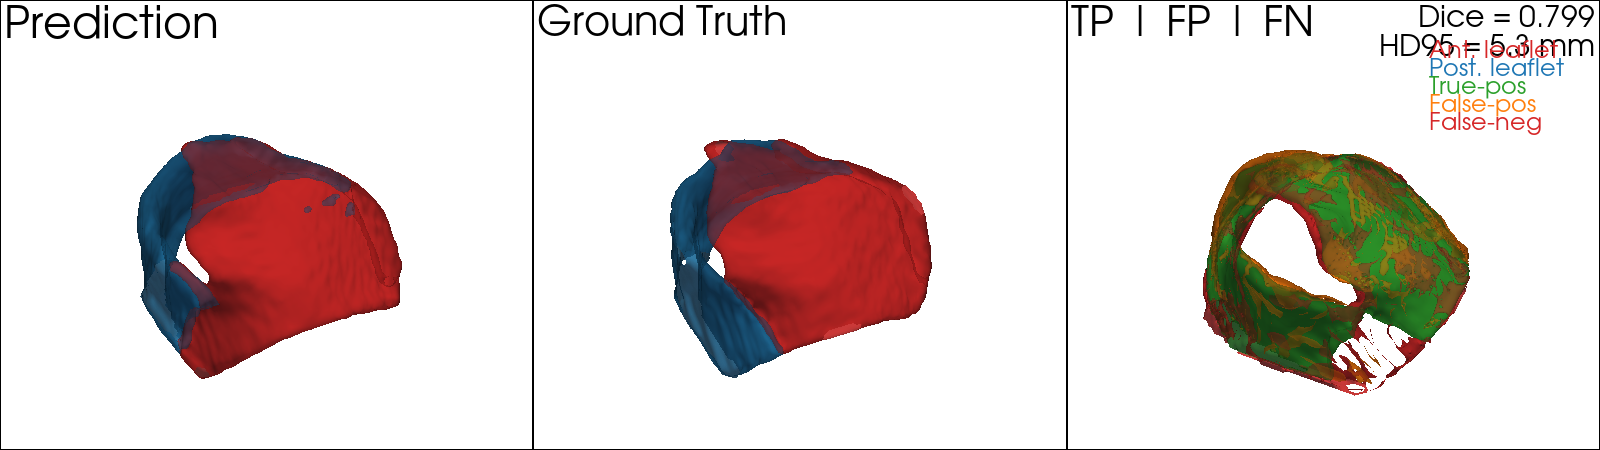

✓ saved /content/qual_pub.png


In [ ]:
# ───────────────── 8.  QUAL viewer (PCA-aligned) ────────────────────────────
import os, random, numpy as np, pyvista as pv, pandas as pd
from skimage import measure
from IPython.display import Image, display
mesh_dir    = f"{DRIVE_ROOT}/meshes"
metrics_csv = f"{DRIVE_ROOT}/test_metrics.csv"
pix         = (0.6, 0.6, 0.6)

# ---------- colour map ------------------------------------------------------
COL_P , COL_A  = "#1f77b4", "#d62728"       # Post / Ant leaflet
COL_TP, COL_FP = "#2ca02c", "#ff7f0e"
COL_FN         = "#d62728"

# ---------- PyVista theme ---------------------------------------------------
pv.start_xvfb()
pv.global_theme.background      = "white"
pv.global_theme.smooth_shading  = True
pv.global_theme.show_scalar_bar = False
pv.global_theme.font.size       = 16
pv.global_theme.window_size     = np.array([1600, 450])

# ---------- helpers ---------------------------------------------------------
def common_crop(a, b):
    union = (a > 0) | (b > 0)
    if not union.any():
        return a, b
    z, y, x = np.nonzero(union)
    z0, z1 = z.min(), z.max() + 1
    y0, y1 = y.min(), y.max() + 1
    x0, x1 = x.min(), x.max() + 1
    return a[z0:z1, y0:y1, x0:x1], b[z0:z1, y0:y1, x0:x1]

def iso(mask):
    if not mask.any():
        return pv.PolyData()
    v, f, *_ = measure.marching_cubes(mask.astype(np.uint8), .5, spacing=pix)
    f = np.c_[np.full(f.shape[0], 3), f].astype(np.int64)
    mesh = pv.PolyData(v, f).clean()
    mesh.smooth_taubin(n_iter=30, inplace=True)
    return mesh

def pca_align(mesh):
    if mesh.n_points < 3:
        return mesh
    pts = mesh.points - mesh.center
    _, _, Vt = np.linalg.svd(pts, full_matrices=False)
    mesh.points = pts @ Vt.T + mesh.center
    return mesh

def coloured_mesh(mask, labels, cmap):
    parts = []
    for lab in labels:
        m = iso(mask == lab)
        if m.n_points:
            colour = np.tile(np.array(pv.Color(cmap[lab]).float_rgb),
                             (m.n_points, 1))
            m["colour"] = colour
            parts.append(m)
    if not parts:
        return pv.PolyData()
    merged = parts[0].merge(parts[1:]) if len(parts) > 1 else parts[0]
    return pca_align(merged)

# ---------- metrics table ---------------------------------------------------
df_metrics = pd.read_csv(metrics_csv) if os.path.exists(metrics_csv) else pd.DataFrame()

# ---------- viewer ----------------------------------------------------------
def render_case(case_id, out_png="/content/qual_pub.png"):
    pred_f = f"{mesh_dir}/{case_id}_pred.npy"
    gt_f   = f"{mesh_dir}/{case_id}_gt.npy"
    if not (os.path.exists(pred_f) and os.path.exists(gt_f)):
        raise FileNotFoundError(f"Masks for {case_id} not found")
    pred = np.load(pred_f).squeeze()
    gt   = np.load(gt_f).squeeze()

    pred, gt = common_crop(pred, gt)

    err = np.zeros_like(gt, dtype=np.uint8)
    err[(pred == gt) & (gt > 0)] = 1     # TP
    err[(pred > 0) & (gt == 0)]  = 2     # FP
    err[(pred == 0) & (gt > 0)]  = 3     # FN

    mp = coloured_mesh(pred, (1, 2), {1: COL_P, 2: COL_A})
    mg = coloured_mesh(gt,   (1, 2), {1: COL_P, 2: COL_A})
    me = coloured_mesh(err,  (1, 2, 3),
                       {1: COL_TP, 2: COL_FP, 3: COL_FN})

    row = df_metrics[df_metrics.case == case_id]
    metrics_txt = ""
    if not row.empty:
        d, h = row.iloc[0]["Dice"], row.iloc[0]["HD95_mm"]
        metrics_txt = f"Dice = {d:.3f}\nHD95 = {h:.1f} mm"

    p = pv.Plotter(shape=(1, 3), off_screen=True)

    # --- panel 0: prediction ---------------------------------
    p.subplot(0, 0)
    p.add_text("Prediction", font_size=18)
    if mp.n_points:
        p.add_mesh(mp, scalars="colour", rgb=True, opacity=0.9)
    p.view_isometric()
    cam = p.camera_position           # cache camera

    # --- panel 1: ground truth -------------------------------
    p.subplot(0, 1)
    p.add_text("Ground Truth", font_size=18)
    if mg.n_points:
        p.add_mesh(mg, scalars="colour", rgb=True, opacity=0.9)
    p.camera_position = cam

    # --- panel 2: error map ----------------------------------
    p.subplot(0, 2)
    p.add_text("TP | FP | FN", font_size=18)
    if me.n_points:
        p.add_mesh(me, scalars="colour", rgb=True, opacity=0.9)
    p.camera_position = cam
    if metrics_txt:
        p.add_text(metrics_txt, position="upper_right", font_size=14)

    # legend (viewport coords)
    names = ["Ant. leaflet", "Post. leaflet",
             "True-pos", "False-pos", "False-neg"]
    cols  = [COL_A, COL_P, COL_TP, COL_FP, COL_FN]
    for i, (t, c) in enumerate(zip(names, cols)):
        p.add_text(t, position=(0.68, 0.86 - 0.04 * i),
                   viewport=True, font_size=12, color=c)

    p.link_views()
    p.show(screenshot=out_png)
    display(Image(out_png))
    print("✓ saved", out_png)

# ---------- quick demo ------------------------------------------------------
example = random.choice([os.path.basename(f["image"]).split("-US")[0]
                         for f in test_files])
print("Visualizing", example)
render_case(example)



In [ ]:
# ==============================================================
#  QUALITATIVE VIEWER  ·  3-panel PCA-aligned surface plots
#  Requires:
#    • DRIVE_ROOT/test_metrics.csv     (written during testing)
#    • DRIVE_ROOT/meshes/*_pred.npy    (predicted label maps)
#    • DRIVE_ROOT/meshes/*_gt.npy      (ground-truth label maps)
# ==============================================================

import os, random, numpy as np, pandas as pd, pyvista as pv
from skimage import measure
from IPython.display import display, Image

# ─────────── configurable paths ─────────────────────────────────
DRIVE_ROOT = "/content/drive/MyDrive/mvseg2023"
mesh_dir   = f"{DRIVE_ROOT}/meshes"
csv_path   = f"{DRIVE_ROOT}/test_metrics.csv"
vox_spacing = (0.6, 0.6, 0.6)          # ⬅ change if you resampled differently

# ─────────── colours (IEEE-friendly) ───────────────────────────
COL = {
    "P":  "#1f77b4",   # posterior leaflet
    "A":  "#d62728",   # anterior leaflet
    "TP": "#2ca02c",
    "FP": "#ff7f0e",
    "FN": "#d62728",
}

# ─────────── PyVista global style ──────────────────────────────
pv.start_xvfb()                         # off-screen renderer in Colab
pv.global_theme.background      = "white"
pv.global_theme.window_size     = np.array([2100, 600])   # wide figure
pv.global_theme.show_scalar_bar = False
pv.global_theme.smooth_shading  = True
pv.global_theme.font.size       = 18

# ─────────── helper fns ────────────────────────────────────────
def tight_crop(a, b):
    union = (a > 0) | (b > 0)
    if not union.any():
        return a, b
    z, y, x = np.nonzero(union)
    z0, y0, x0 = z.min(), y.min(), x.min()
    z1, y1, x1 = z.max() + 1, y.max() + 1, x.max() + 1
    return a[z0:z1, y0:y1, x0:x1], b[z0:z1, y0:y1, x0:x1]

def iso(mask, spacing=vox_spacing, n_iter=30):
    if not mask.any():
        return pv.PolyData()
    v, f, *_ = measure.marching_cubes(mask.astype(np.uint8), 0.5, spacing=spacing)
    f = np.c_[np.full(f.shape[0], 3), f].astype(np.int64)
    mesh = pv.PolyData(v, f).clean()
    mesh.smooth_taubin(n_iter=n_iter, inplace=True)
    return mesh

def pca_align(mesh):
    if mesh.n_points < 3:
        return mesh
    pts = mesh.points - mesh.center
    _, _, vt = np.linalg.svd(pts, full_matrices=False)
    mesh.points = pts @ vt.T + mesh.center
    return mesh

def coloured_poly(mask, labels, lut):
    polys = []
    for lab in labels:
        m = iso(mask == lab)
        if m.n_points:
            col = np.tile(np.array(pv.Color(lut[lab]).float_rgb),
                          (m.n_points, 1))
            m["RGB"] = col
            polys.append(m)
    if not polys:
        return pv.PolyData()
    out = polys[0].merge(polys[1:]) if len(polys) > 1 else polys[0]
    return pca_align(out)

# ─────────── metrics table (optional overlay) ──────────────────
df_met = pd.read_csv(csv_path) if os.path.exists(csv_path) else pd.DataFrame()

# ─────────── main render routine ───────────────────────────────
def show_case(case_id,
              out_png=None,
              autosave=True,
              panel_font=26,
              dpi_scale=3):
    """
    Render a 3-panel figure for `case_id`:
      (A) Prediction, (B) Ground-truth, (C) TP/FP/FN map
    """
    # ---------- resolve I/O ------------------------------------
    if out_png is None:
        out_png = f"/content/{case_id}_qual.png"

    pred_f = f"{mesh_dir}/{case_id}_pred.npy"
    gt_f   = f"{mesh_dir}/{case_id}_gt.npy"
    if not (os.path.exists(pred_f) and os.path.exists(gt_f)):
        raise FileNotFoundError(f"✗ Masks missing for {case_id}")

    pred = np.load(pred_f).squeeze()
    gt   = np.load(gt_f).squeeze()
    pred, gt = tight_crop(pred, gt)

    # ---------- build label & error volumes --------------------
    err = np.zeros_like(gt, np.uint8)
    err[(pred == gt) & (gt > 0)] = 1    # TP
    err[(pred > 0)  & (gt == 0)] = 2    # FP
    err[(pred == 0) & (gt > 0)]  = 3    # FN

    mp = coloured_poly(pred, (1, 2), {1: COL["P"], 2: COL["A"]})
    mg = coloured_poly(gt,   (1, 2), {1: COL["P"], 2: COL["A"]})
    me = coloured_poly(err,  (1, 2, 3),
                       {1: COL["TP"], 2: COL["FP"], 3: COL["FN"]})

    # ---------- metrics overlay text ---------------------------
    txt = ""
    if not df_met.empty and case_id in df_met.case.values:
        row = df_met[df_met.case == case_id].iloc[0]
        txt = f"Dice = {row.Dice:.3f}\nHD95 = {row.HD95_mm:.1f} mm"

    # ---------- plotting ---------------------------------------
    plot = pv.Plotter(shape=(1, 3), off_screen=True)

    # panel A – prediction
    plot.subplot(0, 0)
    plot.add_text("(A) Prediction", font_size=panel_font, font="times")
    if mp.n_points:
        plot.add_mesh(mp, scalars="RGB", rgb=True, opacity=0.9)
    plot.view_isometric(); cam = plot.camera_position

    # panel B – ground truth
    plot.subplot(0, 1)
    plot.add_text("(B) Ground-truth", font_size=panel_font, font="times")
    if mg.n_points:
        plot.add_mesh(mg, scalars="RGB", rgb=True, opacity=0.9)
    plot.camera_position = cam

    # panel C – error map
    plot.subplot(0, 2)
    plot.add_text("(C) TP/FP", font_size=panel_font, font="times")
    if me.n_points:
        plot.add_mesh(me, scalars="RGB", rgb=True, opacity=0.9)
    plot.camera_position = cam
    if txt:
        plot.add_text(txt, position="lower_right", font_size=panel_font - 6,
                      color="black")

    # legend (viewport coords on last panel)
    legend_items = [
        ("Anterior leaflet", COL["A"]),
        ("Posterior leaflet", COL["P"]),
        ("True-positive",    COL["TP"]),
        ("False-positive",   COL["FP"]),
    ]
    for j, (lab, col) in enumerate(legend_items):
        plot.add_text(lab,
                      position=(0.6, 0.9 - 0.07 * j),
                      viewport=True,
                      font_size=panel_font - 8,
                      color=col)

    plot.link_views()
    if autosave:
        # higher-res screenshot
        plot.show(screenshot=out_png, window_size=plot.window_size * dpi_scale)
        display(Image(out_png))
        print("✓ saved", out_png)
    else:
        plot.show()

# ─────────── quick demo on 3 random test cases ─────────────────
random_cases = random.sample(
    [os.path.basename(f["image"]).split("-US")[0] for f in test_files], 3)

for cid in random_cases:
    print(f"Visualizing {cid} …")
    show_case(cid)

ModuleNotFoundError: No module named 'pyvista'

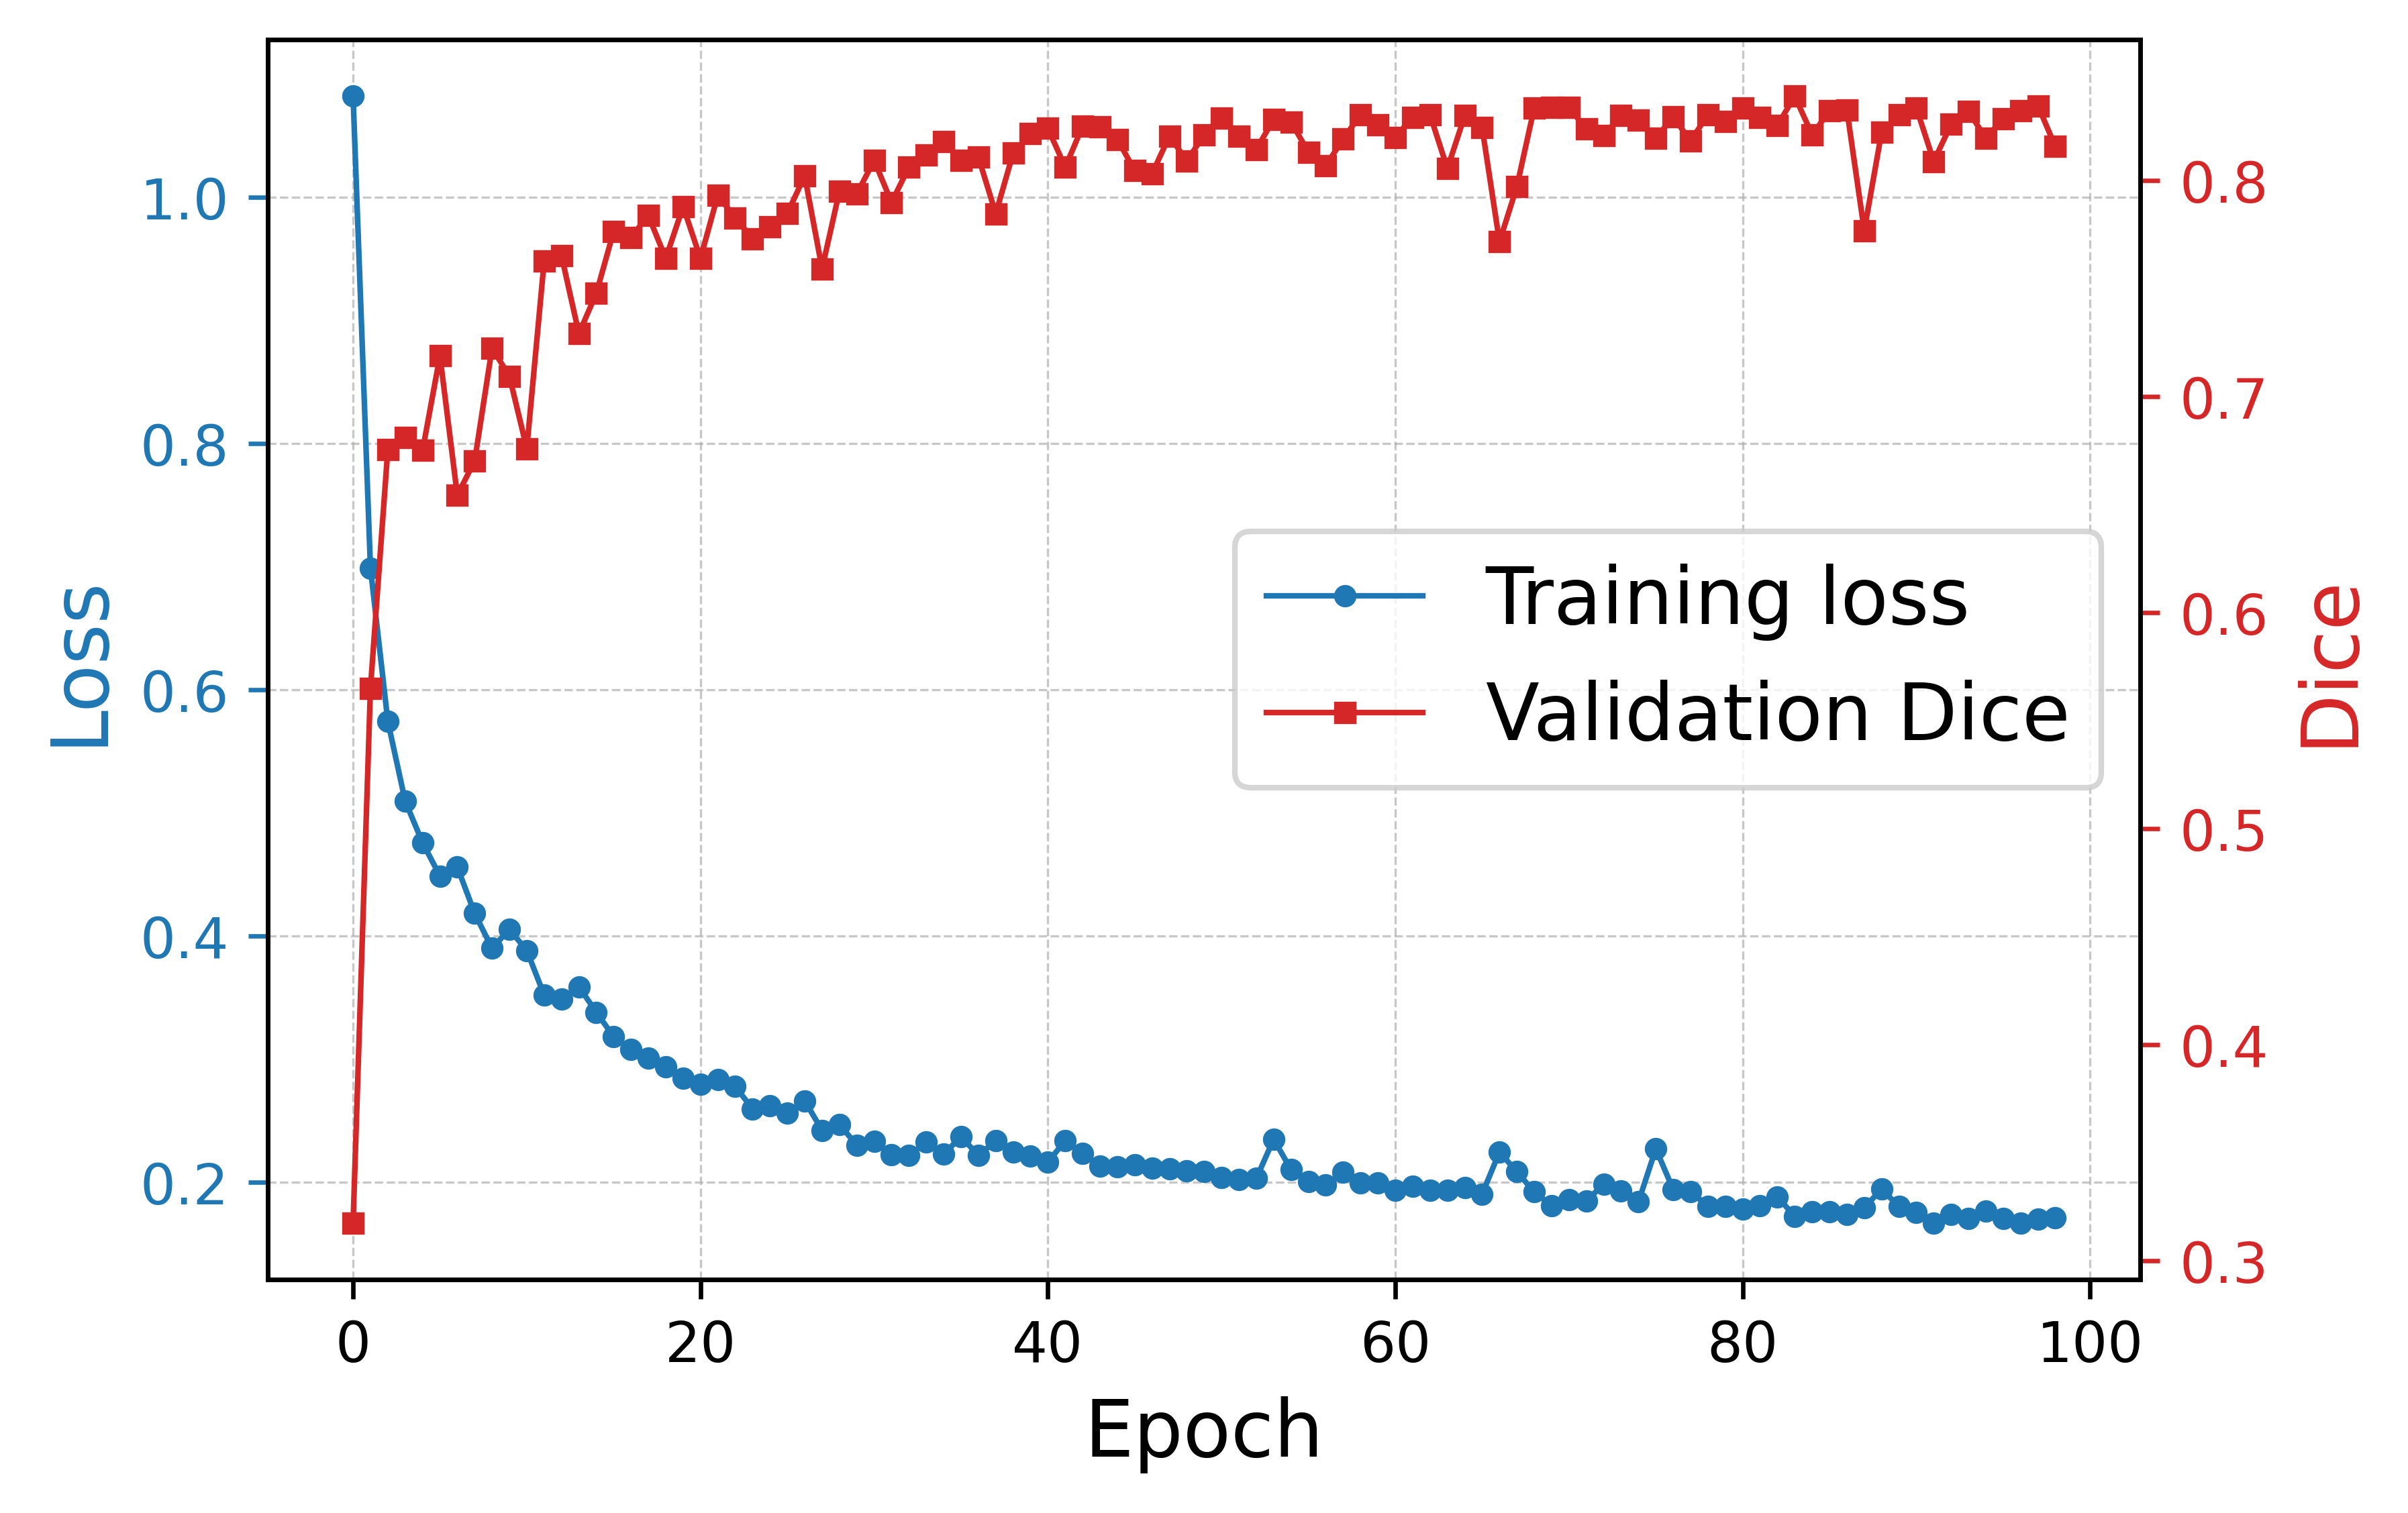

In [ ]:
import matplotlib.pyplot as plt
import numpy as np, re, pathlib

txt = """E000 loss=1.0824  valDice=0.3173
E001 loss=0.6989  valDice=0.5650
E002 loss=0.5745  valDice=0.6756
E003 loss=0.5096  valDice=0.6810
E004 loss=0.4758  valDice=0.6750
E005 loss=0.4488  valDice=0.7188
E006 loss=0.4561  valDice=0.6543
E007 loss=0.4184  valDice=0.6702
E008 loss=0.3900  valDice=0.7224
E009 loss=0.4054  valDice=0.7094
E010 loss=0.3882  valDice=0.6759
E011 loss=0.3521  valDice=0.7626
E012 loss=0.3486  valDice=0.7651
E013 loss=0.3588  valDice=0.7291
E014 loss=0.3381  valDice=0.7477
E015 loss=0.3182  valDice=0.7764
E016 loss=0.3079  valDice=0.7737
E017 loss=0.3008  valDice=0.7837
E018 loss=0.2936  valDice=0.7639
E019 loss=0.2847  valDice=0.7879
E020 loss=0.2794  valDice=0.7639
E021 loss=0.2835  valDice=0.7932
E022 loss=0.2778  valDice=0.7827
E023 loss=0.2595  valDice=0.7730
E024 loss=0.2619  valDice=0.7784
E025 loss=0.2561  valDice=0.7847
E026 loss=0.2661  valDice=0.8022
E027 loss=0.2421  valDice=0.7591
E028 loss=0.2468  valDice=0.7950
E029 loss=0.2301  valDice=0.7938
E030 loss=0.2331  valDice=0.8093
E031 loss=0.2223  valDice=0.7898
E032 loss=0.2217  valDice=0.8062
E033 loss=0.2327  valDice=0.8117
E034 loss=0.2228  valDice=0.8179
E035 loss=0.2369  valDice=0.8094
E036 loss=0.2218  valDice=0.8108
E037 loss=0.2335  valDice=0.7846
E038 loss=0.2245  valDice=0.8126
E039 loss=0.2212  valDice=0.8216
E040 loss=0.2162  valDice=0.8241
E041 loss=0.2338  valDice=0.8061
E042 loss=0.2232  valDice=0.8251
E043 loss=0.2131  valDice=0.8248
E044 loss=0.2127  valDice=0.8190
E045 loss=0.2140  valDice=0.8046
E046 loss=0.2115  valDice=0.8031
E047 loss=0.2108  valDice=0.8206
E048 loss=0.2090  valDice=0.8090
E049 loss=0.2084  valDice=0.8212
E050 loss=0.2038  valDice=0.8288
E051 loss=0.2020  valDice=0.8206
E052 loss=0.2030  valDice=0.8144
E053 loss=0.2349  valDice=0.8283
E054 loss=0.2101  valDice=0.8271
E055 loss=0.2006  valDice=0.8131
E056 loss=0.1975  valDice=0.8068
E057 loss=0.2083  valDice=0.8192
E058 loss=0.1995  valDice=0.8304
E059 loss=0.1992  valDice=0.8259
E060 loss=0.1934  valDice=0.8200
E061 loss=0.1964  valDice=0.8292
E062 loss=0.1933  valDice=0.8304
E063 loss=0.1932  valDice=0.8055
E064 loss=0.1956  valDice=0.8300
E065 loss=0.1903  valDice=0.8245
E066 loss=0.2245  valDice=0.7716
E067 loss=0.2084  valDice=0.7971
E068 loss=0.1921  valDice=0.8336
E069 loss=0.1811  valDice=0.8339
E070 loss=0.1855  valDice=0.8337
E071 loss=0.1847  valDice=0.8239
E072 loss=0.1984  valDice=0.8208
E073 loss=0.1929  valDice=0.8300
E074 loss=0.1839  valDice=0.8278
E075 loss=0.2271  valDice=0.8194
E076 loss=0.1941  valDice=0.8295
E077 loss=0.1924  valDice=0.8182
E078 loss=0.1804  valDice=0.8305
E079 loss=0.1801  valDice=0.8272
E080 loss=0.1779  valDice=0.8335
E081 loss=0.1807  valDice=0.8291
E082 loss=0.1880  valDice=0.8255
E083 loss=0.1723  valDice=0.8390
E084 loss=0.1758  valDice=0.8211
E085 loss=0.1757  valDice=0.8322
E086 loss=0.1736  valDice=0.8327
E087 loss=0.1791  valDice=0.7768
E088 loss=0.1945  valDice=0.8223
E089 loss=0.1801  valDice=0.8304
E090 loss=0.1756  valDice=0.8336
E091 loss=0.1668  valDice=0.8088
E092 loss=0.1738  valDice=0.8260
E093 loss=0.1707  valDice=0.8320
E094 loss=0.1765  valDice=0.8195
E095 loss=0.1707  valDice=0.8286
E096 loss=0.1665  valDice=0.8322
E097 loss=0.1702  valDice=0.8346
E098 loss=0.1709  valDice=0.8157
""".strip().splitlines()

epoch, loss, dice = [], [], []
for ln in txt:
    m = re.search(r"E(\d+).*loss=([\d.]+).*valDice=([\d.]+)", ln)
    if m:
        epoch.append(int(m.group(1)))
        loss.append(float(m.group(2)))
        dice.append(float(m.group(3)))

fig, ax1 = plt.subplots(figsize=(6,4), dpi=600)
ax2 = ax1.twinx()
ax1.plot(epoch, loss, 'o-', c="#1f77b4", ms=3, lw=1, label="Training loss")
ax2.plot(epoch, dice, 's-', c="#d62728", ms=3, lw=1, label="Validation Dice")

ax1.set_xlabel("Epoch",fontsize=14), ax1.set_ylabel("Loss", color="#1f77b4",fontsize=14)
ax2.set_ylabel("Dice", color="#d62728",fontsize=14)
ax1.tick_params(axis='y', colors="#1f77b4")
ax2.tick_params(axis='y', colors="#d62728")
ax1.grid(True, ls='--', lw=.4, alpha=.7)

# gather legends correctly
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
lines  = h1 + h2
labels = l1 + l2

ax1.legend(lines, labels, loc="center right", fontsize=14)


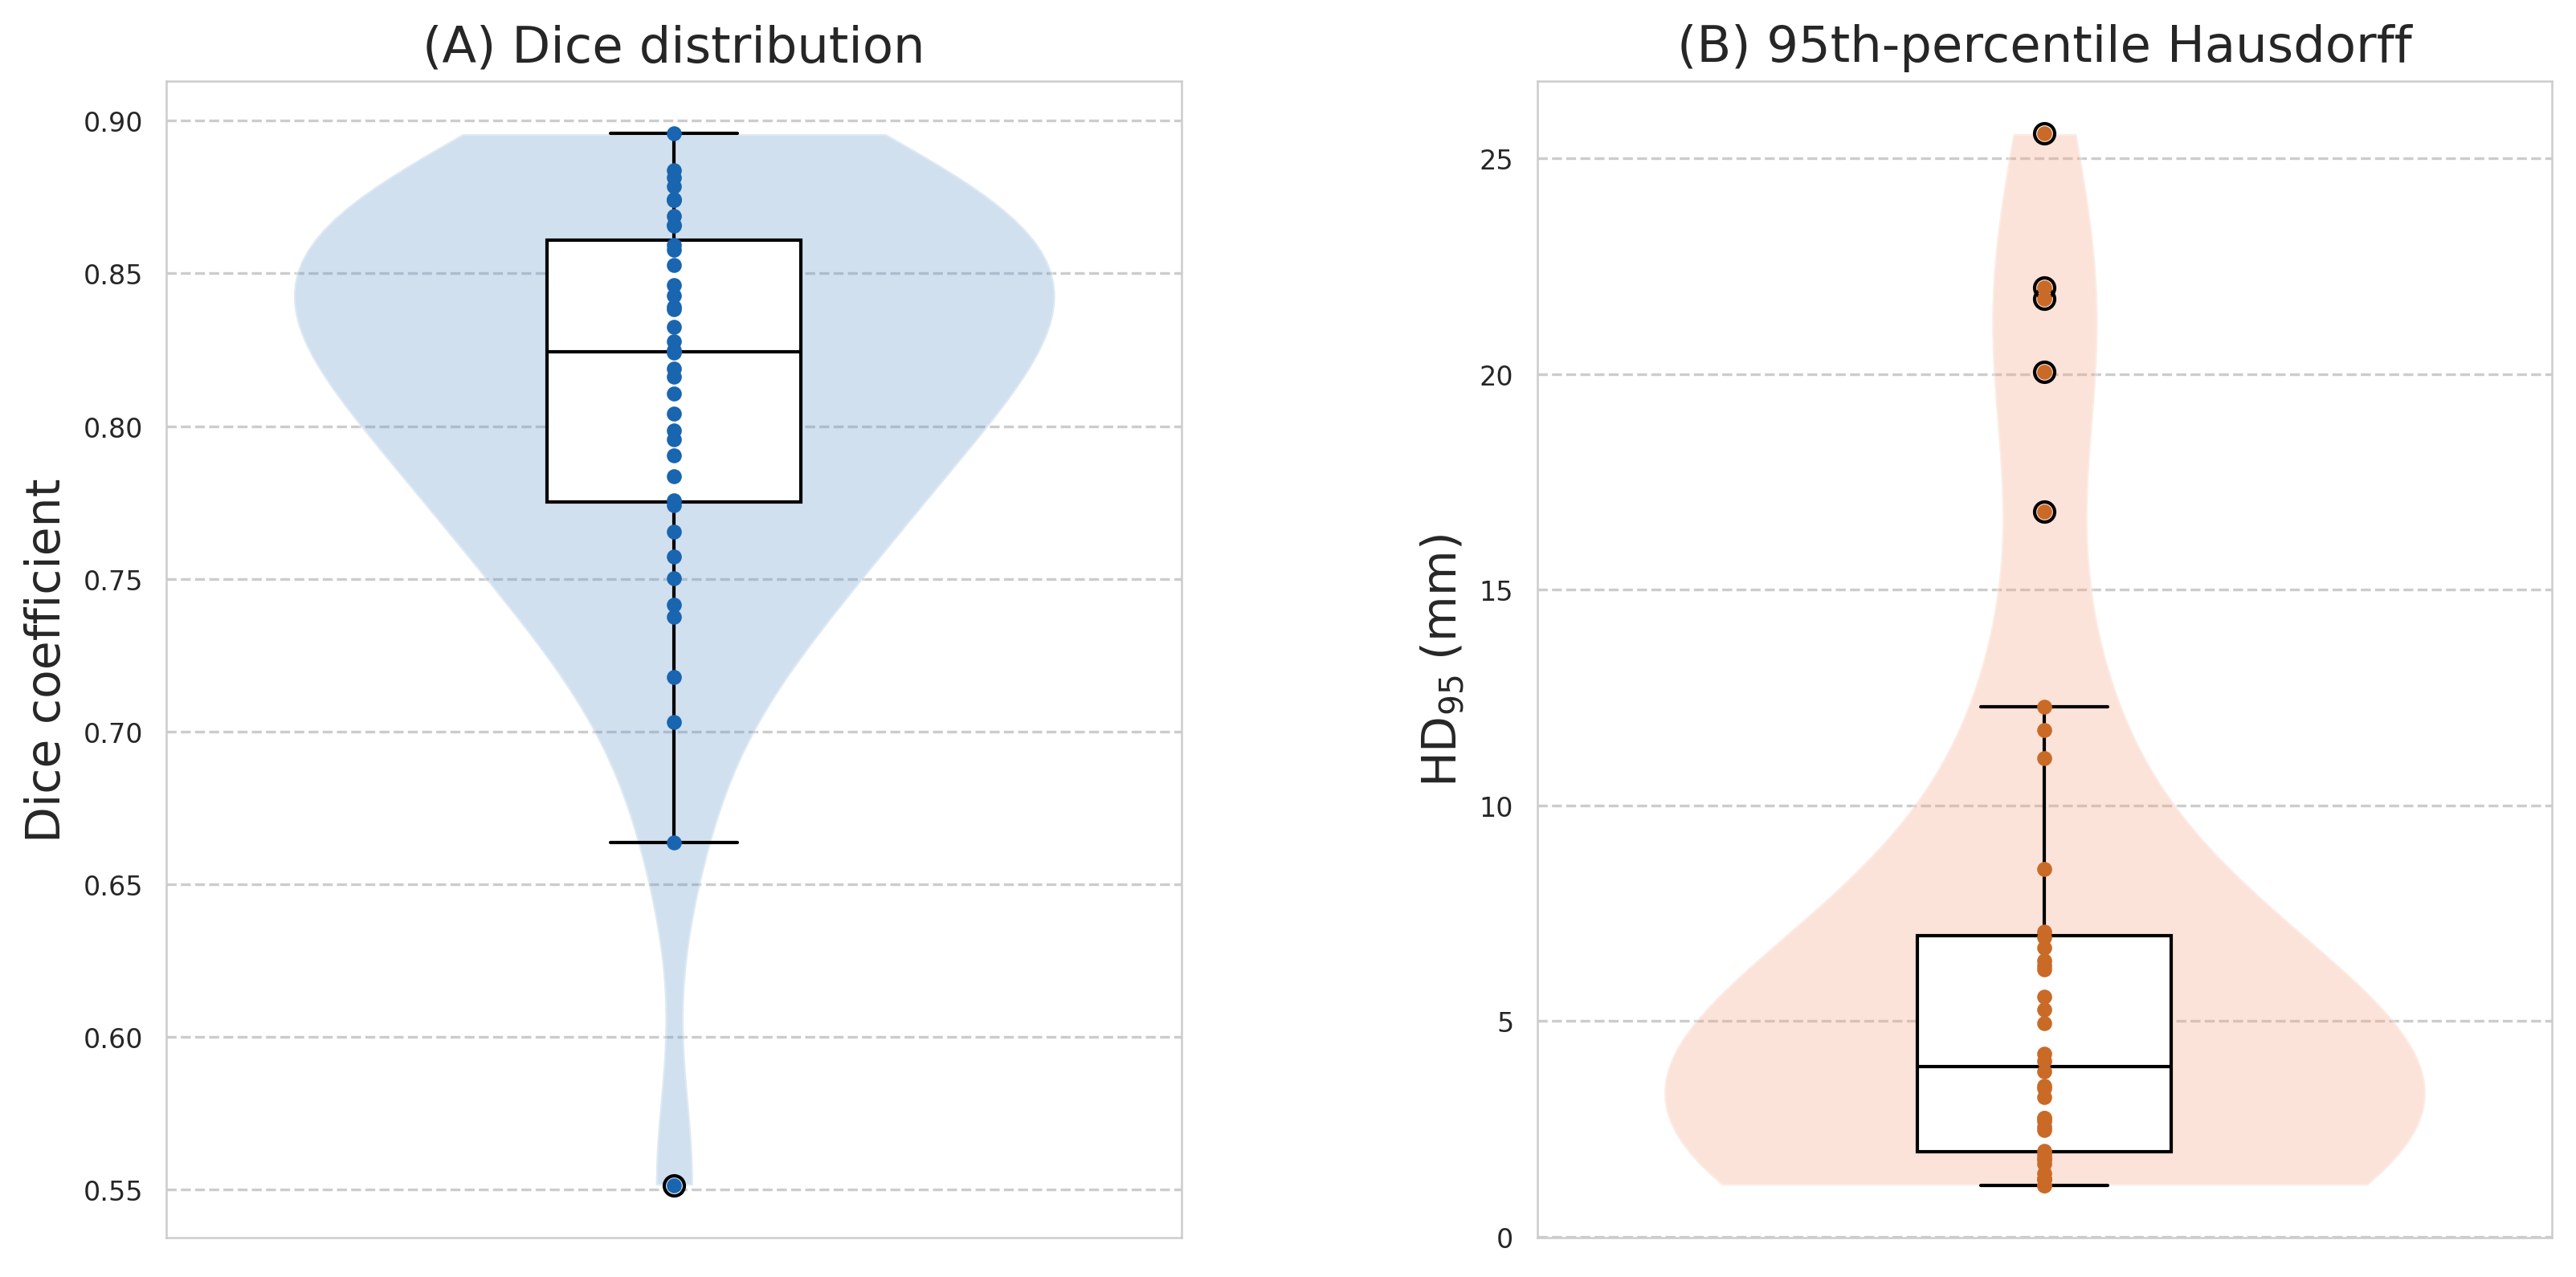

✓ Fig 4 saved → /content/fig4_quantitative.png


In [ ]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

df   = pd.read_csv("/content/drive/MyDrive/mvseg2023/test_metrics.csv")
N    = len(df)

fig, ax = plt.subplots(1, 2, figsize=(11, 6), dpi=300, sharey=False)

# ── panel A : Dice ────────────────────────────────────────────
parts = ax[0].violinplot(df.Dice, positions=[0], widths=.75,
                         showmeans=False, showextrema=False,
                         showmedians=False)
for pc in parts['bodies']: pc.set_facecolor("#6699cc"), pc.set_alpha(.3)
ax[0].boxplot(df.Dice, positions=[0], widths=.25, patch_artist=True,
              boxprops=dict(facecolor="white", edgecolor="black"),
              medianprops=dict(color="black"))
ax[0].scatter([0]*N, df.Dice, s=12, color="#1965B0", zorder=5)
ax[0].set_ylabel("Dice coefficient", fontsize=14)
ax[0].set_xticks([]);  ax[0].set_title("(A) Dice distribution", fontsize=15)

# ── panel B : HD95 ────────────────────────────────────────────
parts = ax[1].violinplot(df.HD95_mm, positions=[0], widths=.75,
                         showmeans=False, showextrema=False,
                         showmedians=False)
for pc in parts['bodies']: pc.set_facecolor("#f4a582"), pc.set_alpha(.3)
ax[1].boxplot(df.HD95_mm, positions=[0], widths=.25, patch_artist=True,
              boxprops=dict(facecolor="white", edgecolor="black"),
              medianprops=dict(color="black"))
ax[1].scatter([0]*N, df.HD95_mm, s=12, color="#ca6a27", zorder=5)
ax[1].set_ylabel(r"$\mathrm{HD_{95}}\;(\mathrm{mm})$", fontsize=14)
ax[1].set_xticks([]);  ax[1].set_title("(B) 95th-percentile Hausdorff", fontsize=15)

# ── global styling ────────────────────────────────────────────
fig.subplots_adjust(wspace=.35, left=.08, right=.98, top=.88, bottom=.08)

out_fig = Path("/content/fig4_quantitative.png")
fig.savefig(out_fig, dpi=300, bbox_inches="tight")

from IPython.display import Image, display
display(Image(out_fig))      # show inline in Colab
plt.close(fig)

print("✓ Fig 4 saved →", out_fig)


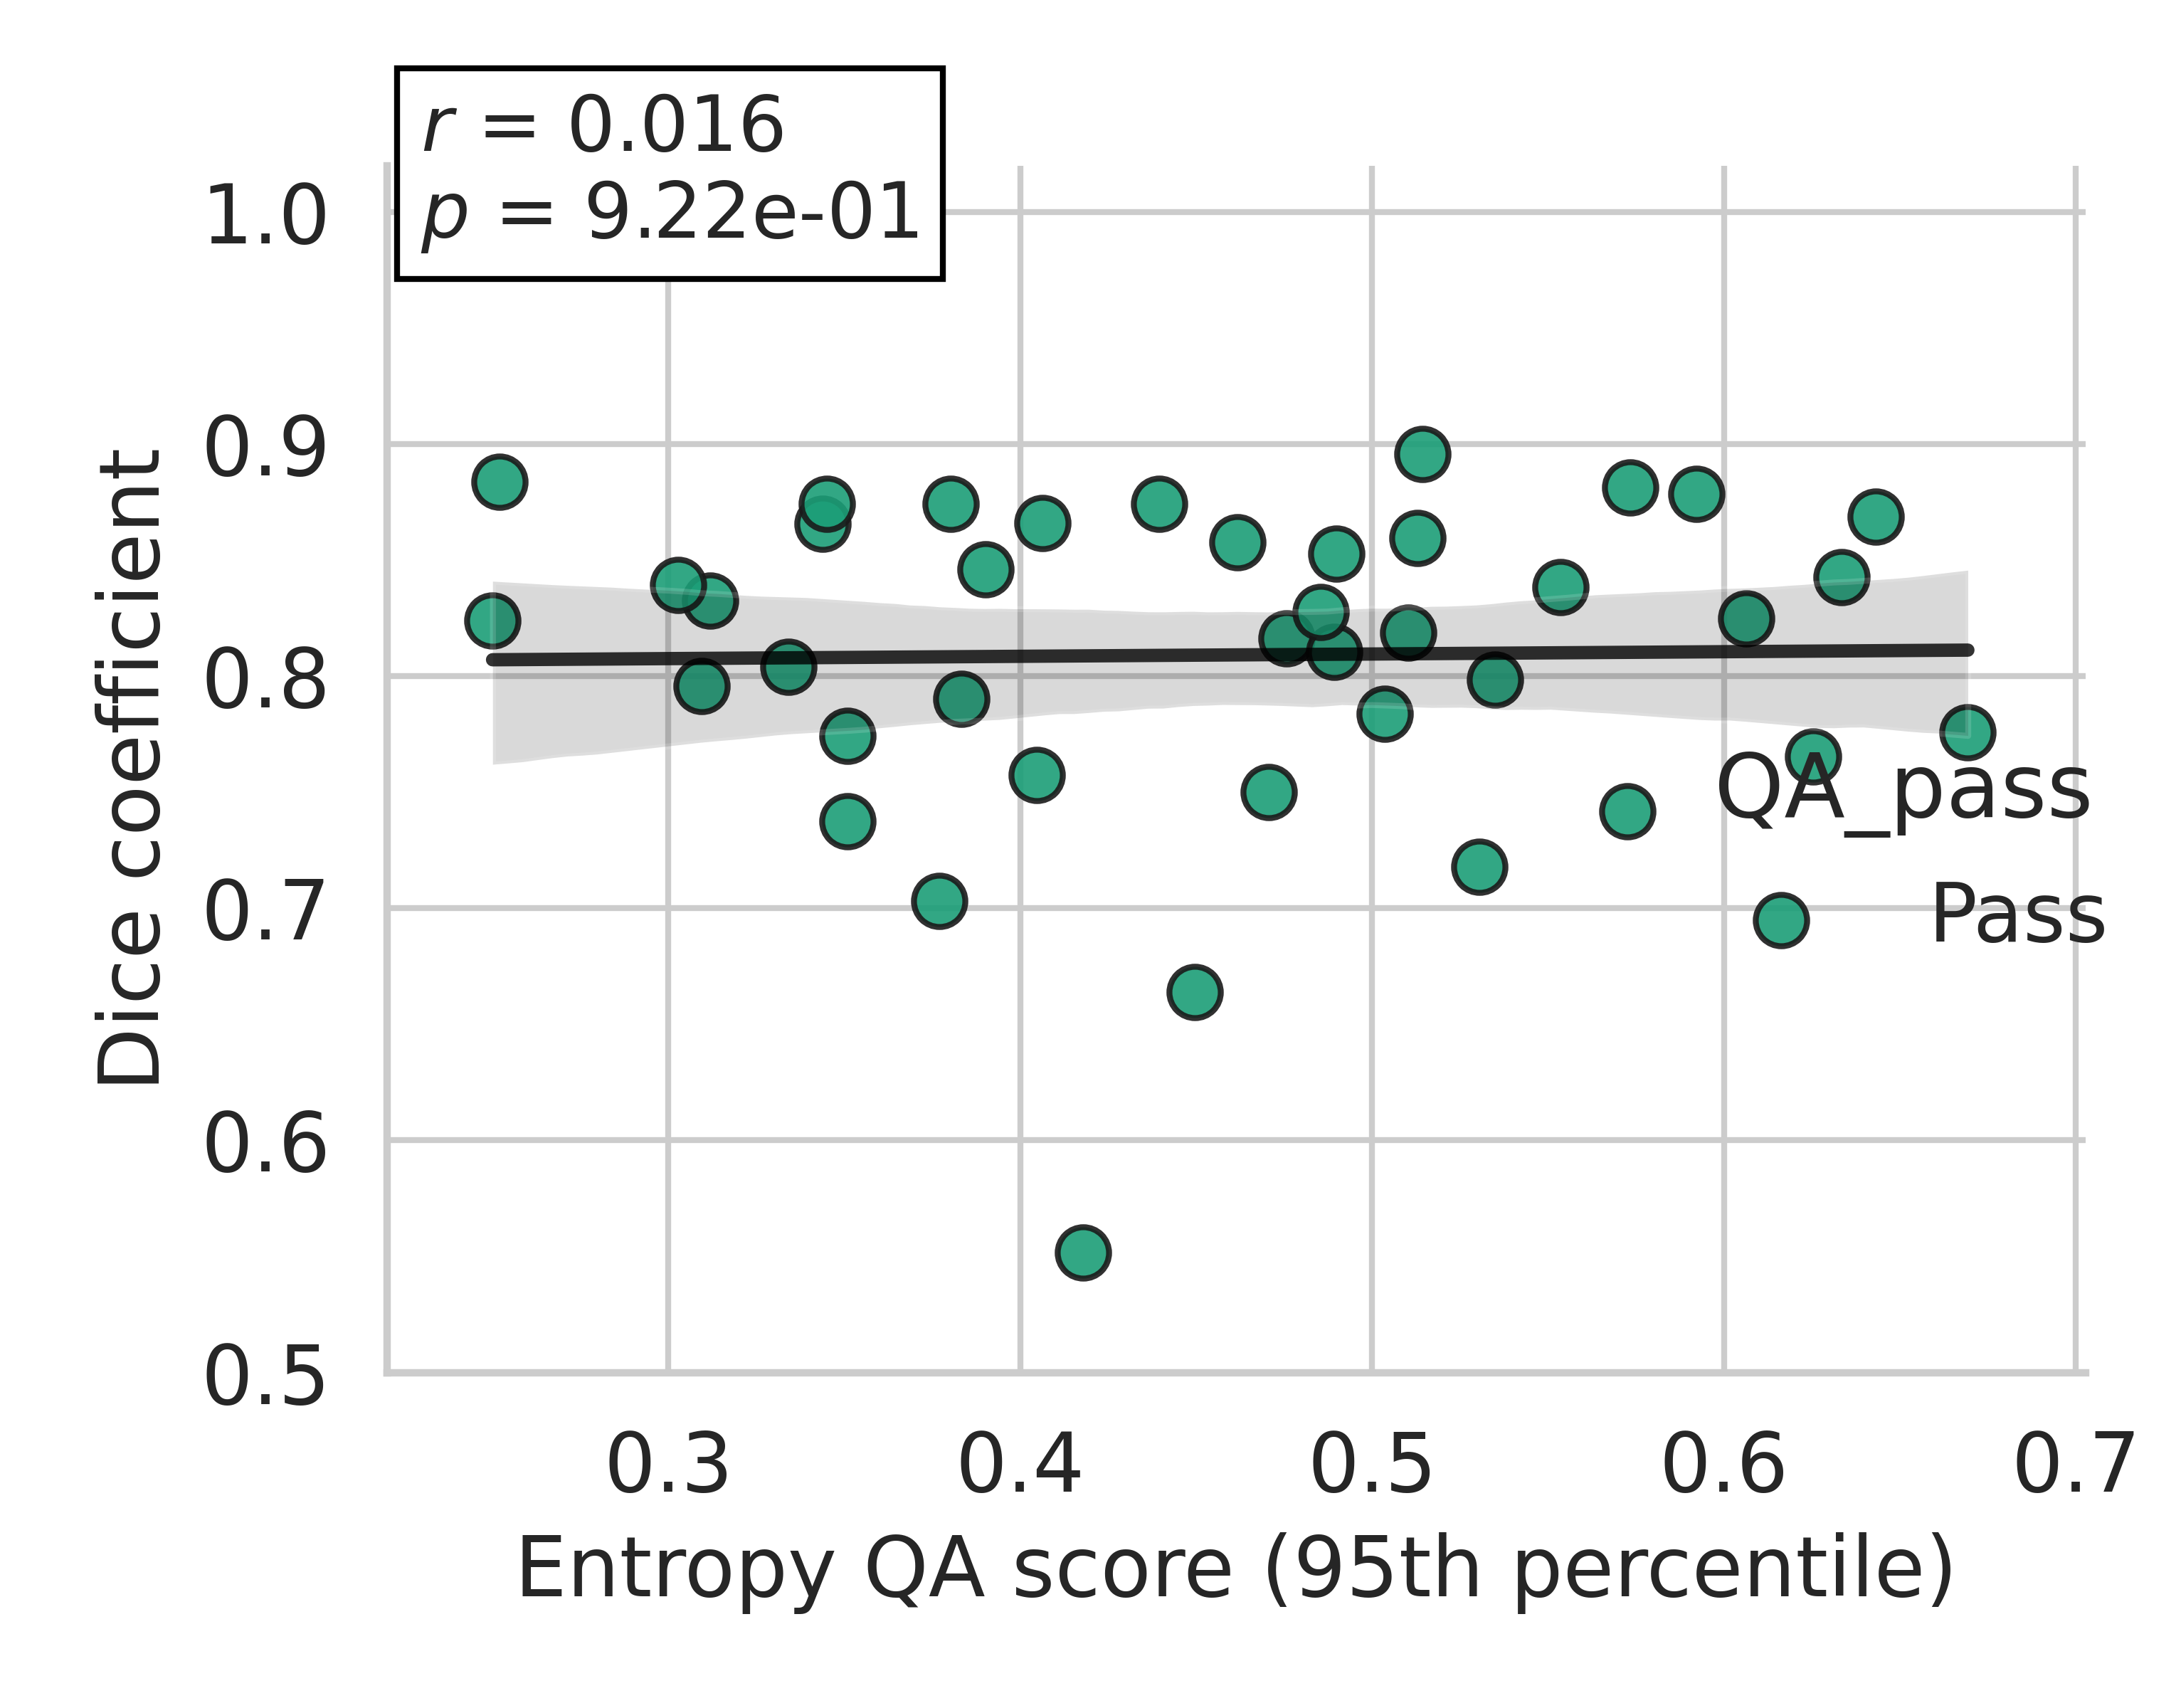

✓ Fig 5 saved → /content/fig5_QA_vs_Dice.png


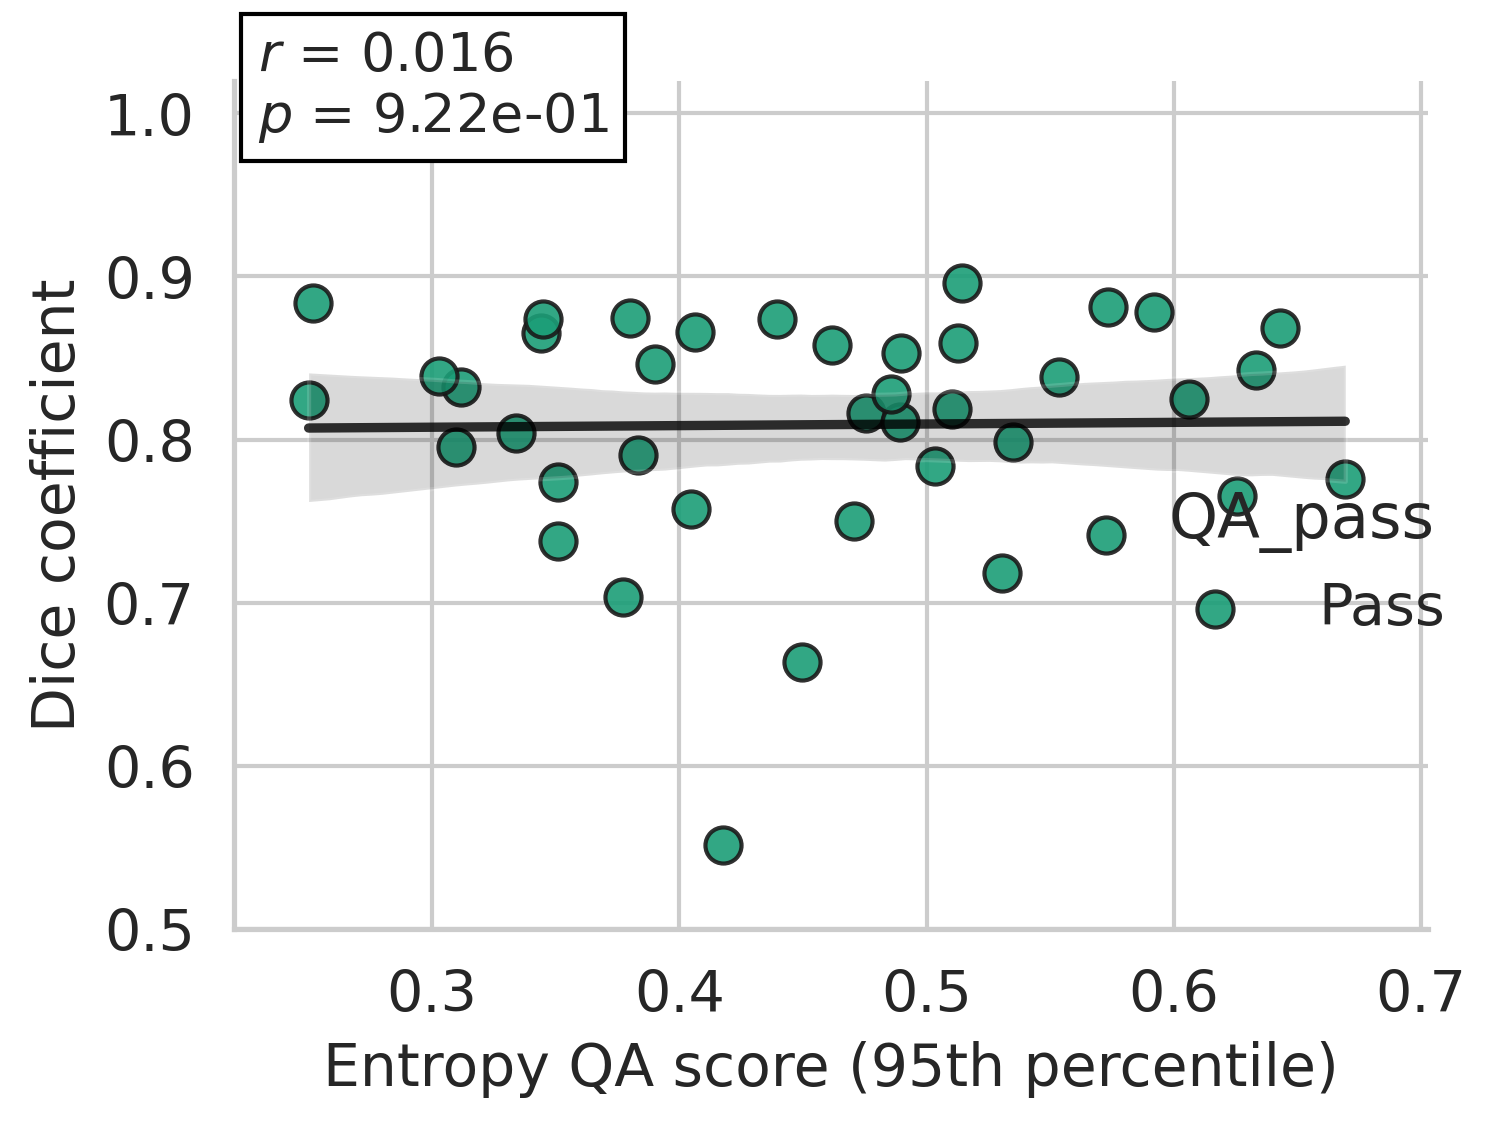

In [ ]:
# ============================================================
#  Fig 5 · QA reliability — Dice  vs  Entropy-95
# ============================================================
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, scipy.stats
from pathlib import Path
from IPython.display import Image, display

CSV_PATH = "/content/drive/MyDrive/mvseg2023/test_metrics.csv"
OUT_FIG  = Path("/content/fig5_QA_vs_Dice.png")
QA_THR   = 0.80                        # the entropy gate you used earlier

# ---------- data -----------------------------------------------------------
df = pd.read_csv(CSV_PATH)
df["QA_pass"] = np.where(df.QA95 < QA_THR, "Pass", "Fail")

r, p = scipy.stats.pearsonr(df.QA95, df.Dice)

# ---------- style ----------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.25, rc={
    "figure.dpi": 300,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans", "Arial"]
})

# ---------- plot -----------------------------------------------------------
g = sns.lmplot(
    data=df, x="QA95", y="Dice", hue="QA_pass",
    palette={"Pass": "#1b9e77", "Fail": "#d95f02"},
    height=4, aspect=1,
    scatter_kws=dict(s=75, edgecolor="k", alpha=.9),   # ← NO lw / linewidths here
    line_kws=dict(color="black", alpha=.8),            # ← idem
    ci=95
)

ax = g.ax
ax.axvline(QA_THR, ls="--", c="grey", lw=1.2)

ax.set_xlabel("Entropy QA score (95th percentile)", fontsize=14)
ax.set_ylabel("Dice coefficient", fontsize=14)
ax.set_xlim(0.22, right=df.QA95.max()*1.05)
ax.set_ylim(.5, 1.02)

# correlation annotation
ax.text(.02, .94, f"$\\it r$ = {r:.3f}\n$p$ = {p:.2e}",
        transform=ax.transAxes, fontsize=13,
        bbox=dict(facecolor="white", edgecolor="black", pad=4))

plt.tight_layout()
plt.savefig(OUT_FIG, dpi=600)
display(Image(OUT_FIG))
print("✓ Fig 5 saved →", OUT_FIG)



In [ ]:
# ── RUNTIME / MEMORY PROFILING ─────────────────────────────────────────────
import time, torch, pandas as pd

timings, vram = [], []

model.eval()                       # already loaded with best weights
torch.cuda.empty_cache()           # clean slate
torch.cuda.reset_peak_memory_stats()

with torch.no_grad(), autocast():
    for batch in tqdm.tqdm(test_ld, desc="Profiling"):
        # ---- identify case (optional, only if you want to keep it per-case) ----
        case_id = os.path.basename(str(batch["image"][0])).split("-US")[0]

        # ---- measure speed & memory ------------------------------------------
        start = time.perf_counter()

        img = pad32(batch["image"]).to(device)
        _   = model(img)                        # forward only (no post-proc)

        torch.cuda.synchronize()                # make sure CUDA is finished
        elapsed_ms = (time.perf_counter() - start) * 1000      # ms
        peak_mem   = torch.cuda.max_memory_allocated() / 1024**2  # MiB

        timings.append(elapsed_ms)
        vram.append(peak_mem)

        # OPTIONAL: print per-case line
        print(f"{case_id:10s} | {elapsed_ms:7.1f} ms | {peak_mem:6.1f} MiB")

# ── aggregate & display table ───────────────────────────────────────────────
tbl = pd.DataFrame({
    "Metric": ["Avg. time / vol.", "Std. time", "Max VRAM"],
    "Value" : [f"{np.mean(timings):.1f} ms",
               f"{np.std(timings):.1f} ms",
               f"{np.max(vram):.1f} MiB"],
})

print("\n" + "="*38)
print("Table 3  Runtime profile (N = {})".format(len(timings)))
print("="*38)
print(tbl.to_string(index=False))
print("="*38)



Profiling:   2%|▎         | 1/40 [00:00<00:19,  2.03it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:   8%|▊         | 3/40 [00:01<00:16,  2.21it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  12%|█▎        | 5/40 [00:01<00:08,  3.98it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  18%|█▊        | 7/40 [00:02<00:12,  2.59it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  20%|██        | 8/40 [00:03<00:10,  3.19it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  28%|██▊       | 11/40 [00:03<00:07,  3.95it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  32%|███▎      | 13/40 [00:04<00:05,  4.78it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  38%|███▊      | 15/40 [00:04<00:07,  3.54it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  42%|████▎     | 17/40 [00:05<00:04,  5.14it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  48%|████▊     | 19/40 [00:05<00:03,  5.84it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  50%|█████     | 20/40 [00:05<00:03,  6.09it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  57%|█████▊    | 23/40 [00:06<00:02,  5.71it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  62%|██████▎   | 25/40 [00:06<00:02,  5.79it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  68%|██████▊   | 27/40 [00:06<00:02,  5.16it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  70%|███████   | 28/40 [00:07<00:02,  5.35it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  78%|███████▊  | 31/40 [00:08<00:02,  3.30it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  88%|████████▊ | 35/40 [00:09<00:01,  4.44it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling:  98%|█████████▊| 39/40 [00:09<00:00,  6.14it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

Profiling: 100%|██████████| 40/40 [00:09<00:00,  4.05it/s]

metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

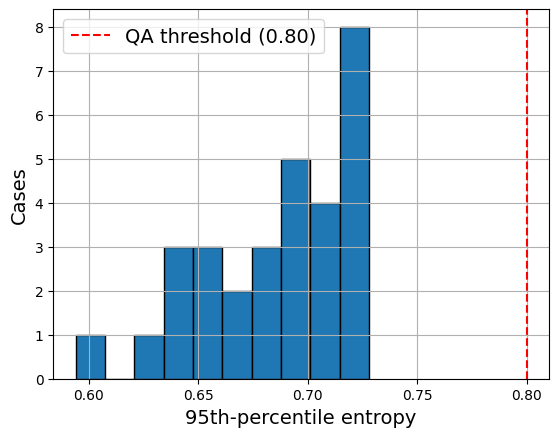

In [ ]:
# ── CELL: histogram of QA scores on the 30 val cases ─────────────
import numpy as np, json
scores = [0.678,0.692,0.688,0.717,0.653,0.719,0.707,0.691,
          0.707,0.722,0.621,0.674,0.717,0.681,0.705,
          0.594,0.637,0.728,0.668,0.646,0.655,0.654,
          0.696,0.716,0.723,0.714,0.639,0.698,0.725,0.685]  # paste yours
plt.figure()
plt.hist(scores, bins=10, edgecolor="k")
plt.axvline(0.80, color="r", ls="--", label="QA threshold (0.80)")
plt.xlabel("95th-percentile entropy",fontsize = 14), plt.ylabel("Cases",fontsize = 14)
#plt.title("QA score distribution (val set)",fontsize = 14)
plt.legend(fontsize = 14); plt.grid(True); plt.show()


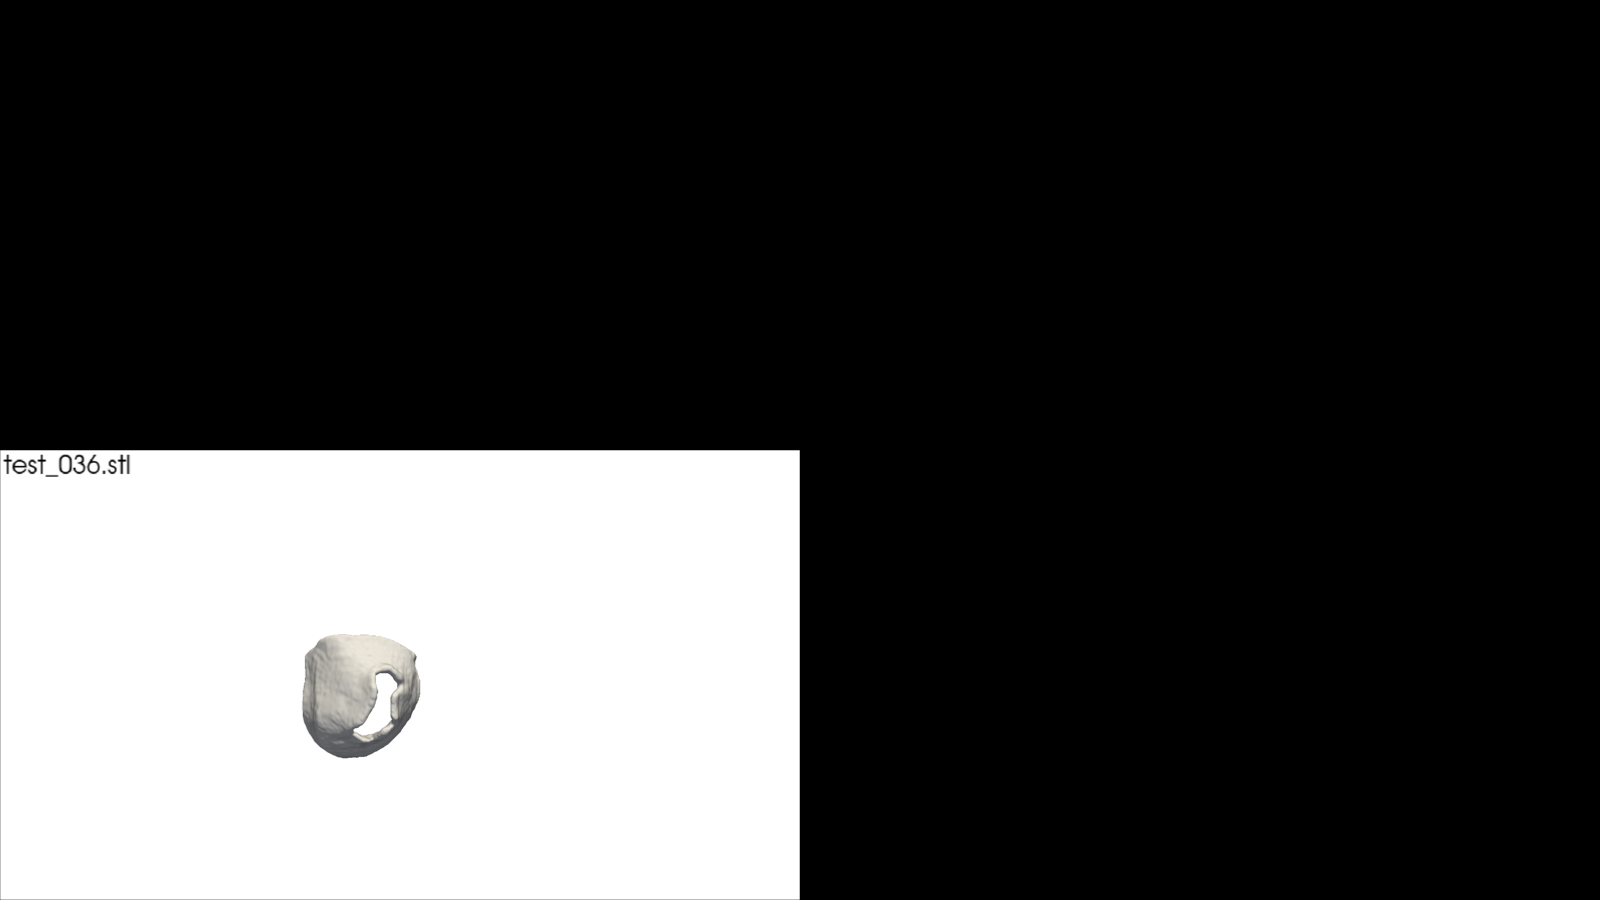

In [ ]:
# ── CELL: static 2×2 montage of STL meshes ──────────────────────
import pyvista as pv, random, glob, os, numpy as np
from IPython.display import Image, display

pv.start_xvfb()                       # head-less rendering

mesh_dir = "/content/drive/MyDrive/mvseg2023/meshes"
files    = random.sample(glob.glob(f"{mesh_dir}/*.stl"), 4)

plotter  = pv.Plotter(shape=(2, 2),
                      off_screen=True)

for i, f in enumerate(files):
    plotter.subplot(i // 2, i % 2)
    plotter.add_text(os.path.basename(f), font_size=10)
    plotter.add_mesh(pv.read(f), color="white", smooth_shading=True)
    plotter.view_xy()

plotter.link_views()
png_path = "/content/mesh_panel.png"
plotter.show(screenshot=png_path)     # nothing pops up; just saves PNG

display(Image(png_path))              # inline preview in Colab
